# Multi Class Classification Model 

For this model I was contrained by a severe data imblanace. The classes are separated into, 'non-demented', 'very mild demented,' 'mild demented,' and 'moderate demented'. I use the same architecture as in the binary classification model with expection of the loss functions. 


In [ ]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import datetime
import neptune.new as neptune
from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import OneHotEncoder, label_binarize
from neptune_tensorflow_keras import NeptuneCallback
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import mixed_precision
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, f1_score, confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.applications import EfficientNetB0, EfficientNetV2B1
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import clone_model
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import LearningRateScheduler

### I keep running into issues with the GPU, namely tensorflow doesn't support windows native so I have to use an older version of tensorflow. Thus I check to make sure that tensorflow is able to access the gpu. 

In [2]:
print("tensorflow version: ", tf.__version__)
print("number of GPU's available", len(tf.config.list_physical_devices('GPU')))

tensorflow version:  2.10.0
number of GPU's available 1


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
file_path = 'Data/oasis_data'
# List all items in data_path and filter out '.DS_Store' and any other non-directory items
classes = [item for item in os.listdir(file_path) if os.path.isdir(os.path.join(file_path, item)) and item != '.DS_Store']
print(classes)

['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


# 1 Import and Pre-process Data

In [5]:
# Map directory names to lists
categories = {
    'Non Demented': [],
    'Very mild Dementia': [],
    'Mild Dementia': [],
    'Moderate Dementia': []
}

image_extensions = '.jpg'  # Image extensions

base_dir = 'Data/oasis_data/'

# Loop through each category
for category in categories.keys():
    dir_path = os.path.join(base_dir, category)
    for dirname, _, filenames in os.walk(dir_path):
        for filename in filenames:
            if os.path.splitext(filename)[1].lower() in image_extensions:
                categories[category].append(os.path.join(dirname, filename))

# lists of the directories
non_demented = categories['Non Demented']
very_mild_demented = categories['Very mild Dementia']
mild_demented = categories['Mild Dementia']
moderate_demented = categories['Moderate Dementia']


In [6]:
print(len(non_demented))
print(len(very_mild_demented))
print(len(mild_demented))
print(len(moderate_demented))

67222
13725
5002
488


# 1.2 Set random seed for reproducablity, and split off traning and testing data from all four classes

I resize the image count based on the imbalanced data set. I leave the mild and moderate classes the same as there are aleary a smaller subset of images.

In [7]:
# Set seed for random sampling
random.seed(42)

# Split off a test set for the moderate_demented class
moderate_demented_train, moderate_demented_test = train_test_split(
    moderate_demented, test_size=0.2, random_state=42
)

# Split off a test set for the mild_demented class
mild_demented_train, mild_demented_test = train_test_split(
    mild_demented, test_size=0.2, random_state=42
)

very_mild_demented = random.sample(non_demented,2500)
# Split off a test set for the very_mild_demented class
very_mild_demented_train, very_mild_demented_test = train_test_split(
    very_mild_demented, test_size=0.2, random_state=42
)

non_demented = random.sample(non_demented, 5000)
# Split off a test set for the non_demented class
non_demented_train, non_demented_test = train_test_split(
    non_demented, test_size=0.2, random_state=42
)

In [8]:
print(len(non_demented))
print(len(very_mild_demented))
print(len(mild_demented))
print(len(moderate_demented))

5000
2500
5002
488


In [9]:
print(len(non_demented_test))
print(len(very_mild_demented_test))
print(len(mild_demented_test))
print(len(moderate_demented_test))


1000
500
1001
98


In [10]:
print(len(non_demented_train))
print(len(very_mild_demented_train))
print(len(mild_demented_train))
print(len(moderate_demented_train))

4000
2000
4001
390


# Using one-hot encoding 

In [11]:
# One-hot encoder for class labels
encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3]]) 

OneHotEncoder()

# 1.4 Process the images. 
Here I processes images from four categories by loading, resizing (I tried multiple sizing 124x124, 224x224 and final the original image size 498x248), and converting them into numpy arrays. The processed images and their labels are stored as numpy arrays.

In [12]:
from PIL import Image
import numpy as np
from sklearn.preprocessing import OneHotEncoder


# Dictionary of categories
categories = {
    'non_demented': non_demented_train,
    'very_mild_demented': very_mild_demented_train,
    'mild_demented': mild_demented_train,
    'moderate_demented': moderate_demented_train
}


data = []
result = []

# Function to process and append data
def process_image(path, label_index):
    img = Image.open(path)
   #img = img.resize((224, 224))  # Correct order (width, height)
    img = np.array(img)
    data.append(img)
    #result.append(label_index)
    result.append(encoder.transform([[label_index]]).toarray())


# Loop through each category
for label_index, (category, paths) in enumerate(categories.items()):
    for path in paths:
        process_image(path, label_index)

# Convert lists to numpy arrays 
data = np.array(data)
result = np.array(result)

In [13]:
result = np.array(result)
result = result.reshape((data.shape[0],4)) 
result.shape

(10391, 4)

In [14]:
data.shape

(10391, 248, 496, 3)

# Process the test images 

In [15]:
# Dictionary of test categories 
test_categories = {
    'non_demented': non_demented_test,
    'very_mild_demented': very_mild_demented_test,
    'mild_demented': mild_demented_test,
    'moderate_demented': moderate_demented_test
}

# Empty lists to store the test data and the corresponding labels
data_test = []
result_test = []

# Function to process and append test data
def process_test_image(path, label_index):
    img = Image.open(path)
   #img = img.resize((224, 224))
    img = np.array(img)
    data_test.append(img)
    #result_test.append(label_index)
    result_test.append(encoder.transform([[label_index]]).toarray())

# Loop through each test category
for label_index, (category, paths) in enumerate(test_categories.items()):
    for path in paths:
        process_test_image(path, label_index)

# Optionally, convert lists to numpy arrays for consistency with training data
data_test = np.array(data_test)
result_test = np.array(result_test)

In [16]:
data_test = np.array(data_test)
data_test.shape

(2599, 248, 496, 3)

In [17]:
result_test = np.array(result_test)
result_test = result_test.reshape((data_test.shape[0],4)) 
result_test.shape

(2599, 4)

In [18]:
x_test = data_test
y_test = result_test
y_test.shape

(2599, 4)

# train test split to split training set

In [19]:
x_train,x_val,y_train,y_val = train_test_split(data,result, test_size=0.20, shuffle=True, random_state=42)

# 2 build the model 
I was experiencing a lot of overfitting issues and tried a myriad of different tuning paramters. I have found that using the Adam optimizer with a learning rate of .0001, and using using learning decay gave the best result over long training periods. Also, adjusting the filter size to the same aspect ratio as the image seemed to have the best results.

I also experimented with Neptune, which is a site I found online to track the model. It became more of a hassle than anything so only used it for a few runs. I left the code in here so that if anyone wants to try them they can. 

In [21]:


# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

run = neptune.init_run(
    project="wrq9/classification-cnn",
    api_token='my api token',
) 

# Define the model
model = Sequential([
    
    Conv2D(32, (5,2), activation='relu', padding='same', input_shape=(248, 496, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional layer with 64 filters
    Conv2D(64, (5,2), activation='relu', padding='same', strides=(1,1)),
    BatchNormalization(),
    MaxPooling2D((3, 3)),

    # Third convolutional layer with 128 filters
    Conv2D(128, (5,2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((3, 3)),
    Dropout(0.5),

    # Fourth convolutional layer with 256 filters
    Conv2D(256, (5, 2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # fifth convolutional layer with 256 filters
    Conv2D(256, (5, 2), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    

    # Flatten the output of the convolutional layers
    Flatten(),

    # dense layer with 512 units
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    # Output layer with 4 units (for 4 classes) with softmax activation
    Dense(4, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

run["model_visualization"].upload('model_diagram.png')

params = {
    "batch_size": 32,
    "epochs": 20,
    "optimizer": "Adam"
}

run["parameters"] = params

def linear_decay(epoch, lr):
    initial_lr = 0.0001  # Assuming this is the starting learning rate
    max_epochs = 100
    decay = initial_lr / max_epochs
    return initial_lr - decay * epoch

lr_scheduler = LearningRateScheduler(linear_decay)

neptune_callback = NeptuneCallback(run=run, base_namespace='metrics')

model.summary(print_fn=lambda x: run["model_summary"].log(x))
model.summary()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/wrq9/classification-cnn/e/CLAS-17
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 248, 496, 32)      992       
                                                                 
 batch_normalization_5 (Batc  (None, 248, 496, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 124, 248, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 248, 64)      20544     
                                                                 
 batch_normalization_6 (Batc  (None, 124, 248, 64)     256       
 hNor

# 2.2 Fit the model

When fitting the model I would change the parameters based on that particular run, I left these in there as examples

In [22]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    callbacks=[neptune_callback,lr_scheduler]
)

# Evaluate the model on the test set
test_scores = model.evaluate(x_test, y_test, verbose=0)
run["test_loss"] = test_scores[0]
run["test_accuracy"] = test_scores[1]

# Stop the run
run.stop()

Epoch 1/20
260/260 [==============================] - 23s 79ms/step - loss: 2.5464 - accuracy: 0.4773 - val_loss: 2.1186 - val_accuracy: 0.5791 - lr: 1.0000e-04
Epoch 2/20
260/260 [==============================] - 19s 74ms/step - loss: 1.9984 - accuracy: 0.6150 - val_loss: 2.6539 - val_accuracy: 0.5541 - lr: 9.9000e-05
Epoch 3/20
260/260 [==============================] - 19s 74ms/step - loss: 1.7964 - accuracy: 0.6633 - val_loss: 1.8968 - val_accuracy: 0.6676 - lr: 9.8000e-05
Epoch 4/20
260/260 [==============================] - 19s 74ms/step - loss: 1.6342 - accuracy: 0.6949 - val_loss: 1.8458 - val_accuracy: 0.6734 - lr: 9.7000e-05
Epoch 5/20
260/260 [==============================] - 19s 74ms/step - loss: 1.4820 - accuracy: 0.7224 - val_loss: 1.8478 - val_accuracy: 0.6696 - lr: 9.6000e-05
Epoch 6/20
260/260 [==============================] - 19s 75ms/step - loss: 1.3538 - accuracy: 0.7409 - val_loss: 1.5513 - val_accuracy: 0.6922 - lr: 9.5000e-05
Epoch 7/20
260/260 [==============

# Test the model and Visualize the results

In [23]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

82/82 [==============================] - 1s 17ms/step - loss: 0.7231 - accuracy: 0.7942
Test Accuracy: 79.42%


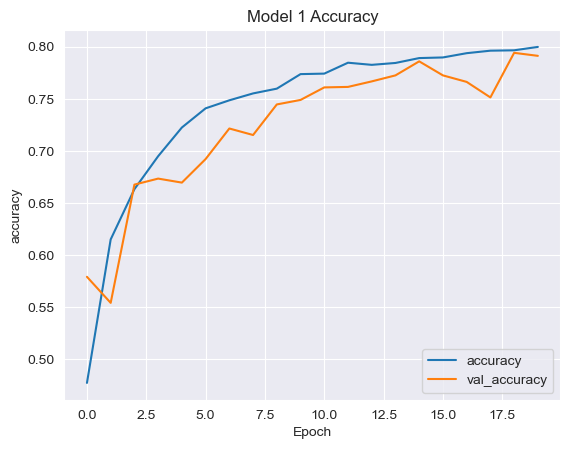

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model 1 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

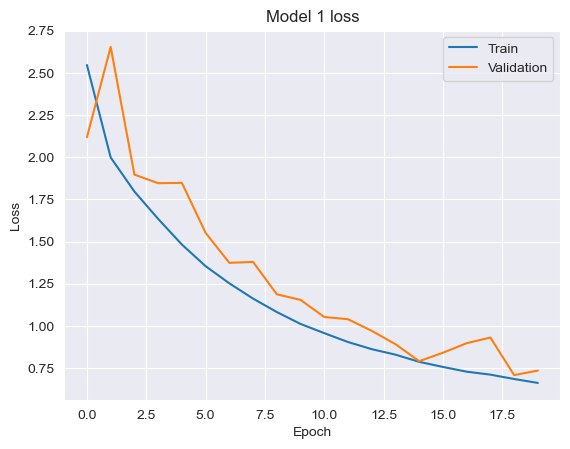

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Pefrmance Metrics for the model

In [26]:
from sklearn.metrics import precision_recall_fscore_support

# Make predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


82/82 [==============================] - 1s 15ms/step
Precision: 0.6596
Recall: 0.7942
F1 Score: 0.7163


### Here I used on roc curve and it clearly looks like the model is overfitting which given the previous metrics seems accurate

82/82 [==============================] - 1s 17ms/step


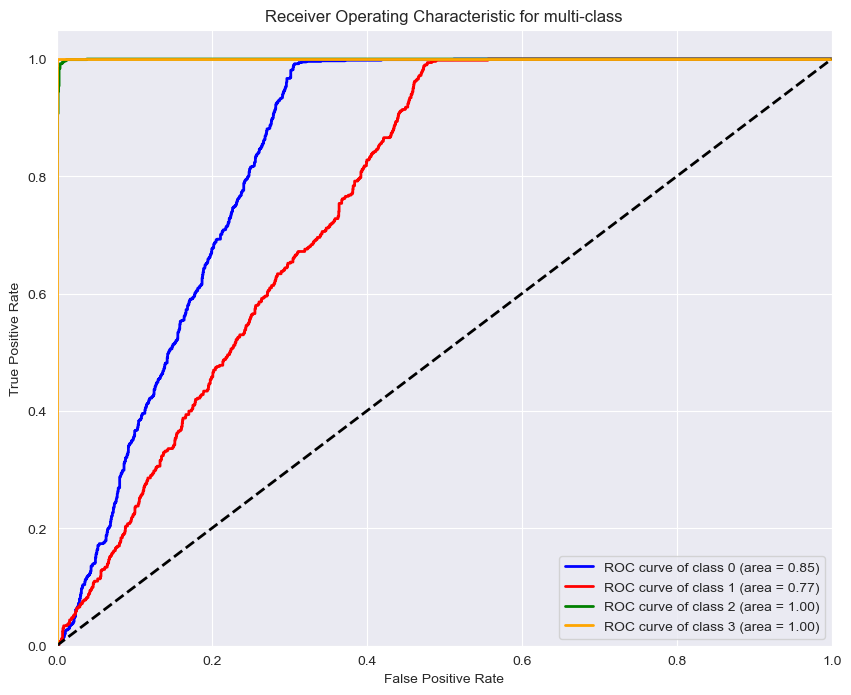

In [27]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt

# Predict probabilities for each class
y_score = model.predict(x_test)

# Binarize the true labels for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

# Set up the figure
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])
lw = 2  # Line width

# Compute ROC curve and ROC area for each class
for i, color in zip(range(4), colors):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc))

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=lw)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()


# K-Fold Cross Validation
I used 3 splits as I was constrained computationally. This was helpful as in tuning and also verifying the model was generalizing well.

In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Define the KFold cross-validator
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Prepare arrays to store results
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Enumerate over each fold
for train_index, test_index in kf.split(data):
    # Split data
    X_train_fold, X_test_fold = data[train_index], data[test_index]
    y_train_fold, y_test_fold = result[train_index], result[test_index]
    
    model = Sequential([
    
    Conv2D(32, (5,2), activation='relu', padding='same', input_shape=(248, 496, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional layer with 64 filters
    Conv2D(64, (5,2), activation='relu', padding='same', strides=(1,1)),
    BatchNormalization(),
    MaxPooling2D((3, 3)),

    # Third convolutional layer with 128 filters
    Conv2D(128, (5,2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((3, 3)),
    Dropout(0.5),

    # Fourth convolutional layer with 256 filters
    Conv2D(256, (5, 2), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # fifth convolutional layer with 256 filters
    Conv2D(256, (5, 2), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    

    # Flatten the output of the convolutional layers
    Flatten(),

    # dense layer with 512 units
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    # Output layer with 4 units (for 4 classes) with softmax activation
    Dense(4, activation='softmax')
])
    # Fit model on the training fold
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Fit model on the training fold
    model.fit(X_train_fold, y_train_fold, epochs=params["epochs"], batch_size=params["batch_size"])
    
    # Predict on the testing fold
    y_pred_fold = model.predict(X_test_fold)
    y_pred_classes_fold = np.argmax(y_pred_fold, axis=1)
    y_true_classes_fold = np.argmax(y_test_fold, axis=1)
    
    # Compute the metrics
    accuracies.append(accuracy_score(y_true_classes_fold, y_pred_classes_fold))
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes_fold, y_pred_classes_fold, average='weighted')
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Output the average scores from all folds
print(f"Average accuracy: {np.mean(accuracies):.4f}")
print(f"Average precision: {np.mean(precisions):.4f}")
print(f"Average recall: {np.mean(recalls):.4f}")
print(f"Average F1 score: {np.mean(f1_scores):.4f}")


Epoch 1/20
217/217 [==============================] - 17s 71ms/step - loss: 2.2904 - accuracy: 0.5604
Epoch 2/20
217/217 [==============================] - 15s 71ms/step - loss: 1.5688 - accuracy: 0.6722
Epoch 3/20
217/217 [==============================] - 15s 71ms/step - loss: 1.3420 - accuracy: 0.7054
Epoch 4/20
217/217 [==============================] - 16s 72ms/step - loss: 1.1981 - accuracy: 0.7308
Epoch 5/20
217/217 [==============================] - 15s 71ms/step - loss: 1.0850 - accuracy: 0.7469
Epoch 6/20
217/217 [==============================] - 15s 71ms/step - loss: 1.0041 - accuracy: 0.7573
Epoch 7/20
217/217 [==============================] - 15s 71ms/step - loss: 0.9452 - accuracy: 0.7635
Epoch 8/20
217/217 [==============================] - 15s 71ms/step - loss: 0.8866 - accuracy: 0.7723
Epoch 9/20
217/217 [==============================] - 15s 71ms/step - loss: 0.8490 - accuracy: 0.7739
Epoch 10/20
217/217 [==============================] - 15s 71ms/step - loss: 0.804

# Visualizing the initial resutls vs K-Fold 

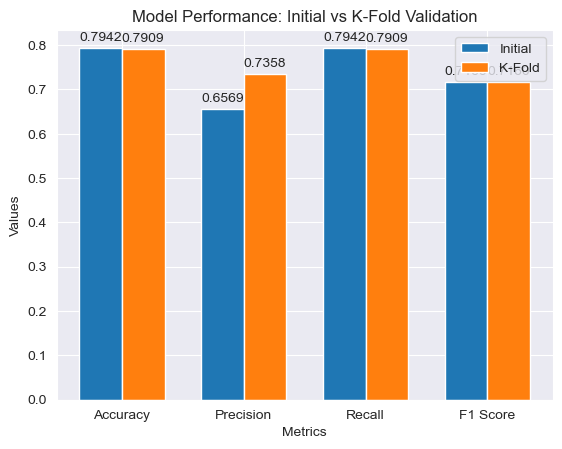

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
initial_results = [79.42, 65.69, 79.42, 71.63]  # Initial model results
kfold_results = [79.09, 73.58, 79.09, 71.60]  # K-fold validation results

# Convert to percentage
initial_results = [x / 100 for x in initial_results]
kfold_results = [x / 100 for x in kfold_results]

# X-axis locations for the groups
ind = np.arange(len(metrics))

# Bar width
width = 0.35

fig, ax = plt.subplots()

# Bars for initial results
initial_bars = ax.bar(ind - width/2, initial_results, width, label='Initial')

# Bars for k-fold results
kfold_bars = ax.bar(ind + width/2, kfold_results, width, label='K-Fold')

# Labeling
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Model Performance: Initial vs K-Fold Validation')
ax.set_xticks(ind)
ax.set_xticklabels(metrics)
ax.legend()

# Label with the value on top of each bar
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(initial_bars)
autolabel(kfold_bars)

plt.show()


# Heat maps were helpful for identifying key features in different layers and adjusting the models based on what I saw in them

1/1 [==============================] - 0s 103ms/step


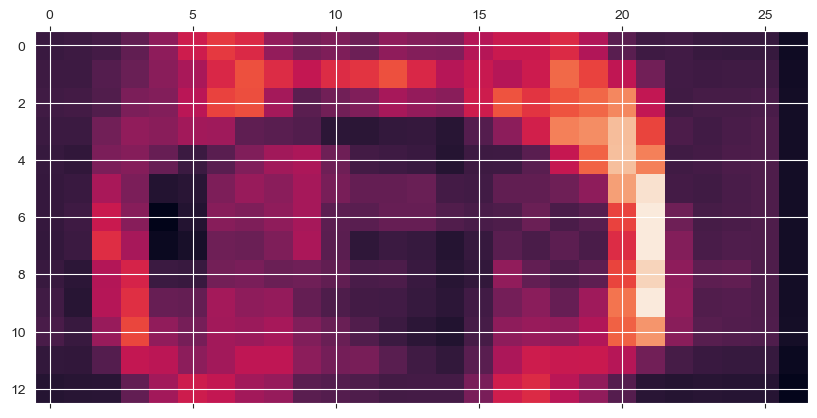

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D

# Assuming 'model' is your trained model and 'img_path' is the path to the image you want to use
img_path = 'Data/oasis_data/Non Demented/OAS1_0001_MR1_mpr-1_145.jpg'


img = load_img(img_path, target_size=(248, 496))  # Resize as 1er your model's input layer
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Model expects a batch of images


# Create a new model that outputs both the original model's output and the last convolutional layer's feature map
layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get feature maps
activations = activation_model.predict(img_array)

# Select layer to visualize or average over multiple layers
feature_maps = activations[3]  # Example: getting the feature map of the fourth Conv layer

# Create heatmap by averaging over all channels and resizing
heatmap = np.mean(feature_maps, axis=-1).squeeze()  # Average across the channels
heatmap = np.maximum(heatmap, 0)  # ReLU to ensure the heatmap is positive
heatmap /= np.max(heatmap)  # Normalize

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Feature Map code to extract the feature maps for various layers

In [50]:
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# function to save feature maps to files
def save_feature_maps(feature_maps, layer_name, save_path):
    num_maps = feature_maps.shape[-1]  # Number of feature maps
    size = feature_maps.shape[1]  # Assuming feature maps are square (size x size)
    n_cols = int(np.sqrt(num_maps))
    n_rows = num_maps // n_cols if num_maps % n_cols == 0 else (num_maps // n_cols) + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    axes = axes.flatten()
    for i in range(n_rows * n_cols):
        ax = axes[i]
        if i < num_maps:
            ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
        ax.axis('off')
    plt.tight_layout()
    
   
    os.makedirs(save_path, exist_ok=True)  

    # Save the full figure
    fig.savefig(os.path.join(save_path, f'{layer_name}_feature_maps.jpg'))
    plt.close(fig)  # Close the figure after saving to free up memory


save_path = 'Data'  

# Load and preprocess the image
img_path = 'Data/oasis_data/Non Demented/OAS1_0001_MR1_mpr-1_135.jpg'
img = load_img(img_path, target_size=(248, 496))
img_array = img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)  # Add the image to a batch where it's the only member


# Get all the convolutional layers and their names
conv_layers = [(layer, layer.name) for layer in model.layers if isinstance(layer, Conv2D)]

# Create models for each convolutional layer's output and save the feature maps
for layer, layer_name in conv_layers:
    activation_model = Model(inputs=model.input, outputs=layer.output)
    feature_maps = activation_model.predict(img_batch)
    save_feature_maps(feature_maps, layer_name, save_path)

# Print the directory where the images are saved
print(f"Feature maps of non-demented saved to: {save_path}")


1/1 [==============================] - 0s 89ms/step
Feature maps of non-demented saved to: Data


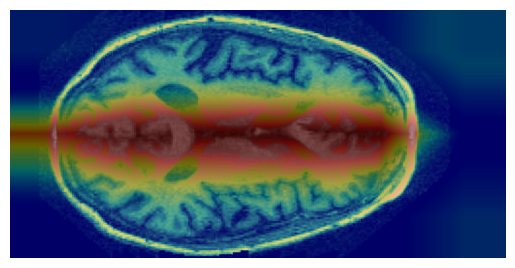

In [60]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tf_explain.core.grad_cam import GradCAM
import numpy as np
import matplotlib.pyplot as plt

#img_path = 'Data/oasis_data/Moderate Dementia/OAS1_0308_MR1_mpr-1_145.jpg'
img_path = 'Data/oasis_data/Moderate Dementia/OAS1_0308_MR1_mpr-1_150.jpg'
img = load_img(img_path, target_size=(248, 496))  # Resize image to match the model's expected input size
img_array = img_to_array(img)  # Convert the image to a numpy array


img_array = img_array / 255.0  

img_batch = np.expand_dims(img_array, axis=0)  # Add the image to a batch where it's the only member

# Grad-CAM visualization
explainer = GradCAM()
grid = explainer.explain((img_batch, None), model, class_index=0)  # Make sure class_index is correct
# ... (previous code for generating 'grid' with Grad-CAM)

# Normalize the heatmap
heatmap = (grid - grid.min()) / (grid.max() - grid.min())

# Remove any extra dimensions from the heatmap using squeeze()
heatmap = heatmap.squeeze()

# Check if there's still an extra dimension and reduce to 2D if necessary
if heatmap.ndim == 3:
    heatmap = heatmap[..., 0]  # Take the first channel if it's a 3D array, this is an arbitrary choice

# Apply the colormap (which also applies an implicit threshold of 0.5)
heatmap_colored = plt.cm.jet(heatmap)

# Convert the colormap to RGB values, discarding the alpha channel if present
heatmap_colored = np.uint8(255 * heatmap_colored[..., :3])

# Load and prepare the original image
original_img = load_img(img_path, target_size=(248, 496))
original_img = np.array(original_img)

# Blend the heatmap with the original image
superimposed_img = heatmap_colored * 0.4 + original_img * 0.6

# Convert to uint8
superimposed_img = np.uint8(superimposed_img)

# Show the superimposed image
plt.imshow(superimposed_img)
plt.axis('off')  # Hide the axes
plt.show()
